# Sort candidate pulse sequences

From the job output, keep only the lines that contain the text "candidate pulse sequence" (can do `cat rl_pulse... | grep "candidate pulse sequence"`) or use regex to delete all lines that don't contain candidate sequences via `^((?!candidate pulse sequence).)*$`.

In [1]:
import sys
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [2]:
path = '../../data/2021-04/20210428-rot_errors/'

In [45]:
candidates = []
with open(os.path.join(path, 'candidates-24.txt')) as file:
    for line in file:
        candidates.append(line)

In [46]:
c2 = []
for c in candidates:
    try:
        m = re.search(r'(.*?) candidate pulse sequence from \d+ \((.*?), array\((.*?)\), (.*?)\)\n', c)
        c2.append({
            'timestamp': m.group(1),
            'sequence': m.group(2),
            'last_pulse': m.group(3),
            'value': float(m.group(4))
        })
    except Exception as e:
        print('exception caught')
        # print(c)

exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught
exception caught


In [47]:
len(c2)

61580

In [48]:
df = pd.DataFrame(c2)

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

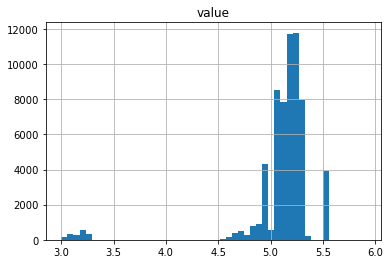

In [49]:
df.hist('value', bins=50)

In [50]:
df.sort_values('value', ascending=False, inplace=True)
# df

In [51]:
df['sequence'] = df['sequence'].apply(lambda x: [int(i) for i in x[1:-1].split(',')])

In [52]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

In [53]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: np.argwhere(x)[0][0])

In [54]:
df['full_sequence'] = df['sequence'] + df['last_pulse'].apply(lambda x: [x])

In [55]:
df.head()

,timestamp,sequence,last_pulse,value,full_sequence
132,2021-04-29 05:28:09.672772,"[4, 1, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 2, 4, ...",4,5.907713,"[4, 1, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 2, 4, ..."
1096,2021-04-29 05:55:16.623819,"[1, 4, 4, 1, 4, 4, 1, 3, 3, 1, 3, 3, 2, 3, 3, ...",4,5.795819,"[1, 4, 4, 1, 4, 4, 1, 3, 3, 1, 3, 3, 2, 3, 3, ..."
2064,2021-04-29 06:08:53.728394,"[1, 4, 4, 1, 4, 4, 1, 3, 3, 1, 3, 3, 2, 3, 3, ...",4,5.795819,"[1, 4, 4, 1, 4, 4, 1, 3, 3, 1, 3, 3, 2, 3, 3, ..."
50590,2021-04-29 14:25:02.888932,"[1, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 4, 2, 4, ...",4,5.506440,"[1, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 4, 2, 4, ..."
3268,2021-04-29 06:23:29.547101,"[4, 1, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 4, 2, ...",1,5.506440,"[4, 1, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 4, 2, ..."


In [56]:
df.to_csv(os.path.join(path, 'candidates-24-sorted.csv'))

In [57]:
df.head().to_csv(os.path.join(path, 'candidates-24-sorted-top.csv'))

In [58]:
print(df.iloc[0]['full_sequence'])

[4, 1, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 2, 4, 4, 2, 4, 4, 1, 4, 4, 1, 4]


## Set up spin system

In [44]:
import qutip as qt
import multiprocessing as mp
sys.path.append('..')
import pulse_sequences as ps
importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

In [61]:
dipolar_strength = 1e2
pulse_width = 1e-5  # time is relative to chemical shift strength
delay = 1e-4
rot_error = 1e-2
N = 3  # number of spins
ensemble_size = 25

In [47]:
X, Y, Z = ps.get_collective_spin(N)

In [62]:
Hsys_ensemble = []
for _ in range(ensemble_size):
    Hsys_ensemble.append(ps.get_Hsys(N=N, dipolar_strength=dipolar_strength))
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=rot_error)
    pulses_ensemble.append(ps.get_pulses(
        H, X, Y, Z, pulse_width=pulse_width, delay=delay, rot_error=rot
    ))

In [63]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Check candidates

In [254]:
# read from file if not loaded above
# df = pd.read_csv('../../data/2021-02/20210219-082529/candidates_sorted.csv')

In [83]:
# unique_sequences = df['full_sequence'].map(lambda x: tuple(x)).unique()
# unique_sequences = [list(i) for i in unique_sequences]
# len(unique_sequences)

In [67]:
N_seq = 50
fidelities = np.zeros(N_seq)
with mp.Pool(4) as p:
    fidelities = p.starmap(ps.get_mean_fidelity,
                           [(c, Utarget, pulses_ensemble)
                            for c in df['full_sequence'].iloc[:N_seq] #unique_sequences[:N_seq]
                           ])
fidelities = np.array(fidelities)

Text(0, 0.5, 'reward estimate (from job)')

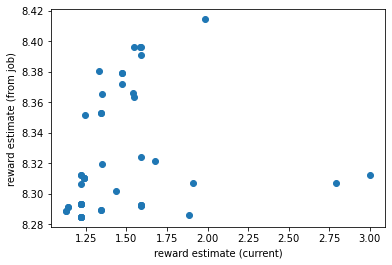

In [68]:
# confirm that calculated rewards match what was calculated from the job
plt.scatter(-np.log10(1 - fidelities), df['value'].iloc[:N_seq])
# plt.plot([8, 8.4], [8, 8.4])
plt.xlabel('reward estimate (current)')
plt.ylabel('reward estimate (from job)')

In [88]:
np.argmin(1 - fidelities), (1 - fidelities).min(), -np.log10((1 - fidelities).min())

(0, 9.850436767422366e-05, 4.0065445124997465)

In [90]:
df.iloc[0]

timestamp                  2021-03-06 23:58:53.951124
sequence            [1, 3, 3, 1, 3, 3, 1, 4, 4, 1, 4]
last_pulse                                          4
value                                         4.18071
full_sequence    [1, 3, 3, 1, 3, 3, 1, 4, 4, 1, 4, 4]
Name: 33942, dtype: object

In [91]:
print(df['full_sequence'].iloc[0])

[1, 3, 3, 1, 3, 3, 1, 4, 4, 1, 4, 4]


In [49]:
df.iloc[0:2]

,timestamp,sequence,last_pulse,value,full_sequence
2429,2021-03-01 12:38:41.265390,"[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ...",1,3.920358,"[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ..."
662,2021-03-01 01:15:00.418460,"[3, 0, 0, 1, 3, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, ...",0,3.851370,"[3, 0, 0, 1, 3, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, ..."


In [271]:
# plt.hist(1 - fidelities, bins=30)
# # fit exponential distribution
# X = np.linspace(0, .1, 100)
# Y = np.exp(-1 / np.mean(1 - fidelities) * X)
# plt.plot(X, Y * 4)

## Format and print pulse sequence

In [1]:
names = [
    r'\tau_{\pi/2}, \tau',
    r'X, \tau',
    r'-X, \tau',
    r'Y, \tau',
    r'-Y, \tau',
]

In [10]:
sequence_string = [names[i] for i in ps.az48_3]

delta = 48 / 8
for i in range(8):
    print('$', ', '.join(sequence_string[int(i*delta):int((i+1)*delta)]), '$')

$ -X, \tau, Y, \tau, Y, \tau, X, \tau, Y, \tau, Y, \tau $
$ -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau $
$ Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau $
$ -Y, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau $
$ -X, \tau, -X, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau $
$ Y, \tau, -Y, \tau, X, \tau, -Y, \tau, -Y, \tau, X, \tau $
$ -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau $
$ -Y, \tau, -X, \tau, -X, \tau, -Y, \tau, -X, \tau, -X, \tau $


$ -X, \tau, Y, \tau, Y, \tau, X, \tau, Y, \tau, Y, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau $
$ Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau $
$ -X, \tau, -X, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, Y, \tau, -Y, \tau, X, \tau, -Y, \tau, -Y, \tau, X, \tau $
$ -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau, -X, \tau, -X, \tau, -Y, \tau, -X, \tau, -X, \tau $

Pulse sequence 23:

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $